In [9]:
import os
import re
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
def parse_array_from_string(array_string):
    """
    Robustly parses a numpy array from its string representation as
    produced by np.array2string.
    """
    try:
        # Find all floating point or integer numbers in the string
        numbers = re.findall(r'-?\d+\.\d*e?-?\d*|-?\d+\.', array_string)
        # Convert to float and reshape into a 2D array
        return np.array(numbers, dtype=float).reshape(-1, 2)
    except (ValueError, IndexError) as e:
        print(f"Warning: Could not parse array string: {e}")
        return np.array([]) # Return empty array on failure


In [11]:
def parse_summary_and_read_data(summary_filepath="data/simulation_summary.txt", data_directory="data"):
    """
    Parses the simulation summary file, including global map data and
    per-trial metadata (including nested patrol vertices). Also reads
e    the associated CSV data for each trial into a pandas DataFrame.

    Args:
        summary_filepath (str): The path to the summary text file.
        data_directory (str): The directory where the CSV files are stored.

    Returns:
        tuple: A tuple containing three dictionaries:
               - (dict): Metadata about the simulation environment (e.g., Map Vertices).
               - (dict): Detailed metadata for each trial. Keys are trial numbers.
               - (dict): DataFrames of path history. Keys are trial numbers.
    """
    environment_metadata = {}
    all_trial_metadata = {}
    all_trial_data = {}

    try:
        with open(summary_filepath, "r") as f:
            content = f.read()
    except FileNotFoundError:
        print(f"Error: Summary file not found at '{summary_filepath}'")
        return None, None, None

    # --- 1. Parse Environment Metadata ---
    env_header_match = re.search(r"--- Simulation Environment ---(.*?)====", content, re.DOTALL)
    if env_header_match:
        header_content = env_header_match.group(1)
        map_vertices_match = re.search(r"Map Vertices:\s*(.*)", header_content)
        if map_vertices_match:
            map_str = map_vertices_match.group(1)
            environment_metadata["Map Vertices"] = parse_array_from_string(map_str)

    # --- 2. Split content into individual trial blocks ---
    trial_blocks = re.split(r"--- Trial Number: \d+ ---", content)
    # Find all trial numbers to associate with blocks
    trial_numbers = re.findall(r"--- Trial Number: (\d+) ---", content)

    if len(trial_numbers) != len(trial_blocks) -1 :
         print("Warning: Mismatch between trial blocks and trial numbers found.")
         return environment_metadata, all_trial_metadata, all_trial_data


    for i, block in enumerate(trial_blocks[1:]): # Skip the content before the first trial
        trial_num = int(trial_numbers[i])
        metadata = {"Trial Number": trial_num}

        # --- 3. Parse Metadata for each Trial ---
        # Simple key-value pairs
        metadata["Total Steps"] = int(re.search(r"Total Steps \(sum over cells\):\s*(\d+)", block).group(1))
        metadata["Associated CSV File"] = re.search(r"Associated CSV File:\s*(.*)", block).group(1)
        source_pos_str = re.search(r"Source Position:\s*(.*)", block).group(1)
        metadata["Source Position"] = parse_array_from_string(source_pos_str)
        emitter_params_str = re.search(r"Emitter Parameters:\s*({.*})", block).group(1)
        metadata["Emitter Parameters"] = ast.literal_eval(emitter_params_str)
        metadata["S_R"] = float(re.search(r"S_R:\s*([\d\.]+)", block).group(1))
        metadata["Number of Cells"] = int(re.search(r"Number of Cells:\s*(\d+)", block).group(1))

        # Nested patrol vertices
        patrols_section_match = re.search(r"Patrol Vertices per Cell:(.*)----------------------------------------", block, re.DOTALL)
        if patrols_section_match:
            patrols_content = patrols_section_match.group(1).strip()
            patrols_by_cell = {}
            # Split by "Cell X:"
            cell_chunks = re.split(r"^\s*Cell\s+\d+:", patrols_content, flags=re.MULTILINE)[1:]
            cell_ids = re.findall(r"^\s*Cell\s+(\d+):", patrols_content, flags=re.MULTILINE)

            for cell_idx, cell_content in enumerate(cell_chunks):
                cell_id = int(cell_ids[cell_idx])
                robots_in_cell = {}
                robot_matches = re.findall(r"Robot\s+(\d+):\s*(\[\[.*?\]\])", cell_content, re.DOTALL)
                for robot_id_str, wps_str in robot_matches:
                    robot_id = int(robot_id_str)
                    robots_in_cell[robot_id] = parse_array_from_string(wps_str)
                patrols_by_cell[cell_id] = robots_in_cell
            metadata["Patrol Vertices"] = patrols_by_cell

        all_trial_metadata[trial_num] = metadata

        # --- 4. Read the corresponding CSV data ---
        csv_filename = metadata["Associated CSV File"]
        csv_filepath = os.path.join(data_directory, csv_filename)
        try:
            print(f"--- Reading data for Trial {trial_num} from {csv_filename} ---")
            trial_df = pd.read_csv(csv_filepath)
            all_trial_data[trial_num] = trial_df
        except FileNotFoundError:
            print(f"Error: CSV file not found at '{csv_filepath}'")
            all_trial_data[trial_num] = None # Or continue

    return environment_metadata, all_trial_metadata, all_trial_data

In [12]:
# The function returns a dictionary of DataFrames.
# You can now work with this data.
env_meta, trial_meta, trial_data = parse_summary_and_read_data()

if env_meta and trial_meta and trial_data:
    print("\n" + "="*50)
    print("PARSING COMPLETE")
    print("="*50 + "\n")

    # Example: Accessing environment data
    print("--- Environment Metadata ---")
    if "Map Vertices" in env_meta:
        print(f"Loaded Map Vertices with shape: {env_meta['Map Vertices'].shape}")
        # print(env_meta['Map Vertices'])
    print("-" * 25)

    # Example: Accessing metadata for a specific trial
    trial_to_inspect = 0
    if trial_to_inspect in trial_meta:
        print(f"--- Metadata for Trial {trial_to_inspect} ---")
        meta_0 = trial_meta[trial_to_inspect]
        print(f"Total Steps: {meta_0['Total Steps']}")
        print(f"Source Position: {meta_0['Source Position']}")

        # Accessing the nested patrol vertices
        if "Patrol Vertices" in meta_0:
            print("Patrol Vertices:")
            patrols = meta_0["Patrol Vertices"]
            # Get vertices for cell 0, robot 0
            if 0 in patrols and 0 in patrols[0]:
                    print(f"  Cell 0, Robot 0 vertices:\n{patrols[0][0]}")
        print("-" * 25)

    # Example: Accessing the DataFrame for a specific trial
    if trial_to_inspect in trial_data and trial_data[trial_to_inspect] is not None:
        print(f"--- DataFrame for Trial {trial_to_inspect} ---")
        df_0 = trial_data[trial_to_inspect]
        print(f"Shape: {df_0.shape}")
        print("Head:\n", df_0.head())
        print("-" * 25)

--- Reading data for Trial 0 from Omni_trial_0.csv ---

PARSING COMPLETE

--- Environment Metadata ---
Loaded Map Vertices with shape: (15, 2)
-------------------------
--- Metadata for Trial 0 ---
Total Steps: 919
Source Position: [[19.96 10.23]]
Patrol Vertices:
  Cell 0, Robot 0 vertices:
[[-2.24844279 -1.47830313]
 [ 1.58259653  2.84260584]
 [ 3.40909381 -2.63562602]
 [-2.24844279 -1.47830313]]
-------------------------
--- DataFrame for Trial 0 ---
Shape: (2769, 6)
Head:
    cell_id  robot_id         x         y  orientation  signal_strength
0        0         0 -2.248443 -1.478303     0.845418        -4.021779
1        0         0 -2.248443 -1.478303     0.845418        -4.021779
2        0         0 -2.182101 -1.403478     0.845418        -4.021779
3        0         0 -2.115759 -1.328653     0.845418        -4.005568
4        0         0 -2.049417 -1.253829     0.845418        -3.989306
-------------------------


In [16]:
MAP_VERTICES = env_meta.get("Map Vertices", None)
TRIAL_NUM = 0

source_pos = trial_meta[TRIAL_NUM].get("Source Position", None)[0]
print(source_pos)

[19.96 10.23]


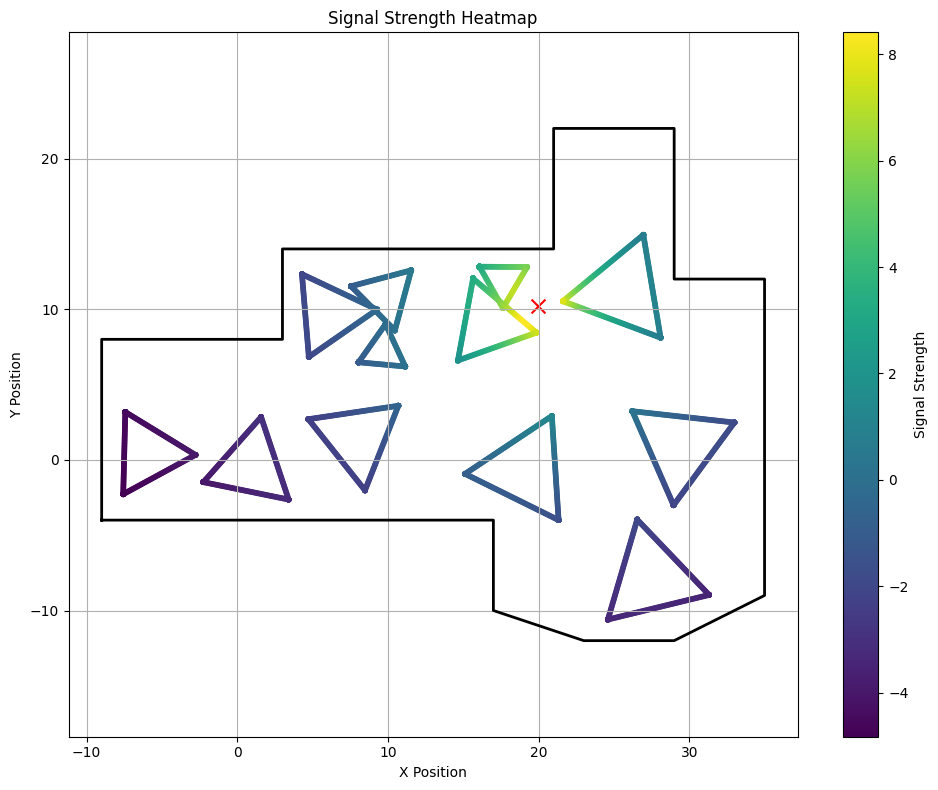

In [17]:
def plot_signal_strength_heatmap(ax, trial_data, source):
    
    ax.plot(
        MAP_VERTICES[:, 0],
        MAP_VERTICES[:, 1],
        color='black',
        linewidth=2,
        label="Map Boundary")
    
    ax.scatter(
        source[0], 
        source[1], 
        color='red', 
        marker='x',
        s=100, 
        label="Source Position"
    )
    
    sc = ax.scatter(
        trial_data['x'], 
        trial_data['y'], 
        c=trial_data['signal_strength'], 
        cmap='viridis', 
        s=10
    )
    plt.colorbar(sc, label="Signal Strength")
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")
    ax.set_title("Signal Strength Heatmap")
    ax.grid(True)
    ax.axis("equal")


fig, ax = plt.subplots(figsize=(10, 8))
plot_signal_strength_heatmap(ax, trial_data[TRIAL_NUM], source_pos)
plt.tight_layout()
plt.show()


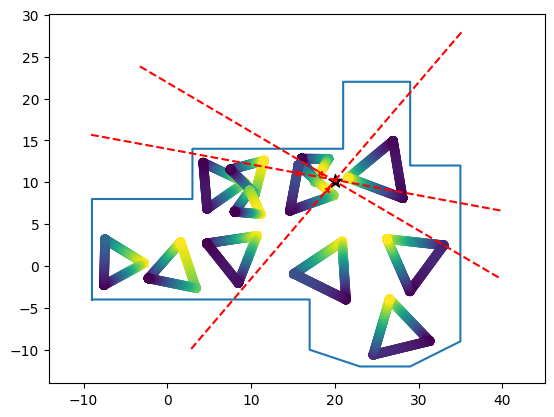

919
0.04251701729086305


In [24]:
fig, ax = plt.subplots()
ax.plot(MAP_VERTICES[:, 0], MAP_VERTICES[:, 1])
# ax.scatter(SIGNAL_SOURCE_POS[0], SIGNAL_SOURCE_POS[1], marker="x", color="blue", s=50)

orthogonal_lines = []  # Add this at the top of your plotting code

for cell_id, cell_group in trial_data[TRIAL_NUM].groupby("cell_id"):
    
    for robot_id, robot in cell_group.groupby("robot_id"):
        
        ax.scatter(robot["x"], robot["y"], c=robot["signal_strength"], cmap="viridis")

        vertices = trial_meta[TRIAL_NUM]["Patrol Vertices"][cell_id][robot_id]

        for i in range(len(vertices) - 1):  # closed loop assumed
            start_x, start_y = vertices[i]
            end_x, end_y = vertices[i + 1]

            # Match start and end vertices
            start_match = robot[
                np.isclose(robot["x"], start_x) & np.isclose(robot["y"], start_y)
            ]
            end_match = robot[
                np.isclose(robot["x"], end_x) & np.isclose(robot["y"], end_y)
            ]

            if not start_match.empty and not end_match.empty:
                
                if i == 0:
                    start_idx = start_match.index[0]
                else:
                    start_idx = start_match.index[-1]
                end_idx = end_match.index[-1]

                i1, i2 = sorted([start_idx, end_idx])
                df_split = robot.loc[i1:i2]

                max_strength_row = df_split.loc[df_split["signal_strength"].idxmax()]

                # Skip if max point is at vertex
                if not (
                    (np.isclose(max_strength_row["x"], start_x) and np.isclose(max_strength_row["y"], start_y))
                    or
                    (np.isclose(max_strength_row["x"], end_x) and np.isclose(max_strength_row["y"], end_y))
                ) and max_strength_row["signal_strength"] >= 2:
                    ax.scatter(
                        max_strength_row["x"],
                        max_strength_row["y"],
                        marker="x",
                        color="r",
                        s=10,
                    )

                    # Calculate gradient of segment
                    dx = end_x - start_x
                    dy = end_y - start_y
                    gradient = np.inf if np.isclose(dx, 0.0) else dy / dx

                    # Perpendicular gradient
                    if np.isclose(gradient, 0.0):
                        perp_grad = np.inf
                    elif np.isinf(gradient):
                        perp_grad = 0.0
                    else:
                        perp_grad = -1 / gradient

                    # Line through max point with gradient = perp_grad
                    length = 50.0  # adjustable
                    x0, y0 = max_strength_row["x"], max_strength_row["y"]

                    if np.isinf(perp_grad):
                        x_vals = [x0, x0]
                        y_vals = [y0 - length / 2, y0 + length / 2]
                    else:
                        dx_line = length / 2 / np.sqrt(1 + perp_grad**2)
                        x_vals = [x0 - dx_line, x0 + dx_line]
                        y_vals = [perp_grad * (x - x0) + y0 for x in x_vals]

                    orthogonal_lines.append((x0, y0, perp_grad))
                    ax.plot(x_vals, y_vals, "r--")

            else:
                print(f"Segment skipped: no match for robot {robot_id} in cell {cell_id}, segment {i}")
                
A_vals = []
b_vals = []

for x0, y0, m in orthogonal_lines:
    if np.isinf(m):  # vertical line: x = x0 → 1·x + 0·y = x0
        A_vals.append([1.0, 0.0])
        b_vals.append(x0)
    elif np.isclose(m, 0.0):  # horizontal line: y = y0 → 0·x + 1·y = y0
        A_vals.append([0.0, 1.0])
        b_vals.append(y0)
    else:
        # General case: y - y0 = m(x - x0) → m x - y = m x0 - y0
        A = m
        B = -1.0
        C = m * x0 - y0
        A_vals.append([A, B])
        b_vals.append(C)

A = np.array(A_vals)
b = np.array(b_vals)

# Solve least squares: minimize ||Ax - b||
intersection, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)

ax.scatter(*intersection, color="black", marker="*", s=100, label="Intersection")

ax.axis("equal")
plt.show()

def point_error(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

print(trial_meta[TRIAL_NUM]["Total Steps"])
print(point_error(intersection, source_pos))